In [2]:
import numpy as np
from scipy.integrate import odeint
from pylab import *
import scipy.constants as const
from numba import double
from numba.decorators import jit, autojit
from scipy.constants import m_e,c,e, epsilon_0
import matplotlib.pyplot as plt
from pylab import title, show

In [3]:
# -----
# Input
# -----

n_e = 1.e24 # Plasma density
lambda_0 = 800.e-9 #laser wavelength
FWHM = 1.19e-5
E_max = 2 
a0 = 1.2

In [5]:
# ----------
# Parameters
# ----------

omega_0 = 2*np.pi*c/lambda_0 # Omega of the laser

# Density distribution
def n(zz):  
    return n_e * ones(zz.size)

# Plasma frequency
def omega_p(zz): 
    return sqrt(n(zz)*e**2/(epsilon_0*m_e))

# Initial electric field of the plasma in V/m
def E_0(zz):
    return c*m_e*omega_p(zz)/e 

# Normalized plasma phase velocity
def beta_p(zz):
    return 1-omega_p(zz)**2/(2*omega_0**2)
    
# Plasma wave phase velocity
def gamma_p(zz):
    return np.sqrt(1/(1-beta_p(zz)**2))

# Plasma wavenumber
def k_p(zz): 
    return omega_p(zz)/c

#ENVELOPE
def a(psi,max_a):
    sigma = FWHM/(np.sqrt(2*np.log(2)))
    laser_a = max_a*np.exp(-(psi)**2/(2*sigma**2))
    return(laser_a)

In [8]:
# --------------------------------- 
# Quasi static plasma wave equation
# ---------------------------------

# Potential (XI DEPENDENCE)
#def potentialeq(phi,xi,z,zi): # Potential equation
#    return array([phi[1],((1+a(xi*k_p(z)[zi],a0,RMS)**2)/(2*(phi[0]+1))-0.5)*(kp(z)[zi]/1e6)**2])

# Potential (PSI DEPENDENCE)
def potentialeq(phi,psi,z,zi):
    return array([phi[1],gamma_p(z)[zi]**2 * (beta_p(z)[zi]*(np.sqrt(1/(1 - (1+ a(psi,a0)**2)/(gamma_p(z)[zi]**2 * (1+phi[0])**2))))-1)])

# Phi min
def get_phi_min(E_max,z):
    return (-1+1/(2*gamma_p(z)**2))*(1-1/E_max**2) + E_max**2/(4*gamma_p(z)**2)

In [9]:
# -----
# PLOTS
# -----


fig, ax = plt.subplots(figsize=(12,5))

psi = np.linspace(-2*np.pi,2*np.pi,1e2)
z = np.linspace(0, 1000, 100)
    
# Initial conditions
phiinit = array([0,0]) 
    
# Solve the quasi static plasma wave equation
phi = list(map(lambda x: odeint(potentialeq, phiinit, psi, args = (z,x,)),range(10)))

# Plot of the solution
#ax.plot(psi/np.pi,phi[3][:,0], linestyle='--', label="$a_0 =$ "+str("%.1f" % a0)+"")

# Plot of the trapping condition
    
def left_side(zz): # Left side of the trapping equation
    return 1 + get_phi_min(E_max,zz) - phi[3][:,0]

def right_side(zz): # Right side of the trapping equation
    return np.sqrt(1+a(psi,a0)**2)/gamma_p(zz)

def condition_fullfilled(zz): # Checks if the trapping condition is fullfilled (right_side() >= left_side())
    diff = np.zeros_like(psi, dtype=object)
    diff = np.where(right_side(zz)-left_side(zz) < 0,0,right_side(zz)-left_side(zz))
    return diff # Just =/= 0 if condition is fullfilled

# Plot the condition 
ax.plot(psi/np.pi,condition_fullfilled(z),label="$a_0 =$ "+str("%.1f" % a0)+"")
    
# Plot the left and the right side of the trapping condition equation
#ax.plot(psi/np.pi,right_side(z)-left_side(z),label="$a_0 =$ "+str("%.1f" % a0)+"")
#ax.plot(psi/np.pi,a(psi,a0,RMS), linestyle='--')

# Set the labels
ax.set_xlabel(r'$\psi\,[\pi]$',fontdict={'fontsize':20})
ax.set_ylabel('$H_S - H_i$',fontdict={'fontsize':20})

# Plot an example of the laser profile
ax.plot(psi/np.pi,a(psi,1.2), linestyle='--', color="grey", label="Laser")

# Make the legend
legend = ax.legend(loc='upper left', shadow=True)
for label in legend.get_texts():
    label.set_fontsize('medium')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

/Users/sebastian/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


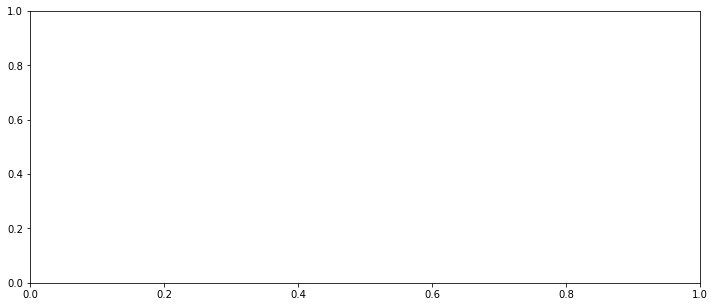

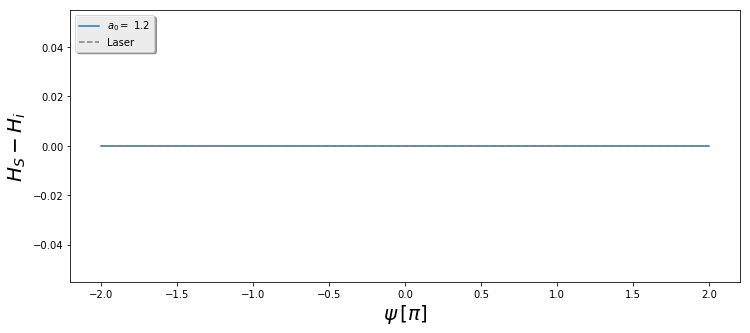

In [10]:
plt.show()